In [11]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


https://pythonspeed.com/articles/pandas-load-less-data/

In [1]:
import pandas as pd

from helpers import create_timeseries

forecast_days = 28
days_ahead = 1

shift_days = days_ahead - 1

start_test_date = 1914

calendar_df = pd.read_csv('./data/calendar.csv', dtype={'event_type_1': 'category'})

train_df = pd.read_csv('./data/sales_train_validation.csv', dtype={
    'id': 'category',
    'item_id': 'category',
    'dept_id': 'category', 
    'cat_id': 'category', 
    'store_id': 'category', 
    'state_id': 'category'})

# Rename the date column to save memory
date_cols_rename = {
     x: int(x.strip('d_')) 
     for x in train_df.columns 
     if 'd_' in x
}

train_df = train_df.rename(columns=date_cols_rename)

X = create_timeseries(train_df, date_cols_rename.values())

# Downcast the sales and date columns
X['sales'] = pd.to_numeric(X['sales'], downcast='integer')
X['d'] = pd.to_numeric(X['d'], downcast='integer')

X.info(verbose=False, memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58327370 entries, 0 to 58327369
Columns: 8 entries, id to sales
dtypes: category(6), int16(2)
memory usage: 671.3 MB


In [2]:
def downcast_cols(df: pd.DataFrame, select_type: str, cast_type: str)  -> pd.DataFrame:
    for col in df.select_dtypes(include=["int"]).columns:
        df[col] = pd.to_numeric(df[col], downcast=cast_type)
    return df

In [3]:
calendar = (calendar_df
    .assign(is_weekend=lambda df: df['weekday'].apply(lambda x: x in ['Saturday', 'Sunday']))
    .assign(d=lambda df: df['d'].apply(lambda x: int(x.strip('d_'))))
    [['snap_CA', 'snap_TX', 'snap_WI', 'is_weekend', 'wm_yr_wk', 'wday', 
      'month', 'event_type_1', 'd']])
              
calendar = downcast_cols(calendar, "int", "integer")

X = (X
     .merge(calendar, on='d', how='left')
     .sort_values(['id', 'd']))

In [4]:
import numpy as np

def snap_values(state):
    return X.iloc[np.where(X['state_id'] == state)][f'snap_{state}']

X['snap'] = (snap_values('CA')
     .append(snap_values('TX'), verify_integrity=True)
     .append(snap_values('WI'), verify_integrity=True)
     .sort_index())

X = X.drop(['snap_CA', 'snap_TX', 'snap_WI'], axis=1)

In [5]:
prices_df = pd.read_csv('./data/sell_prices.csv', dtype={'store_id': 'category',
                                                         'item_id': 'category'})

prices_df['wm_yr_wk'] = pd.to_numeric(prices_df['wm_yr_wk'], downcast='integer')
prices_df['sell_price'] = pd.to_numeric(prices_df['sell_price'], downcast='float')

# TODO prices has null values
X = (X
     .merge(prices_df, on=['wm_yr_wk', 'store_id', 'item_id'], how='left')
     .drop('wm_yr_wk', axis=1))

In [67]:
X.info(verbose=False, memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58327370 entries, 0 to 58327369
Columns: 14 entries, id to sell_price
dtypes: bool(1), category(7), float32(1), int16(2), int8(3)
memory usage: 3.6 GB


In [ ]:
# If price is non - the product is not yet for sale?

# Features

In [6]:
from helpers import add_lagged_features, add_rolling

def calculate_timebase_features(X):

    X = add_lagged_features(X, [1, 3, 7, 14, 21, 365], shift_days)   

    X = add_rolling(X, 'mean', [5, 50], shift_days)
    X = add_rolling(X, 'min', [5, 50], shift_days)
    X = add_rolling(X, 'max', [5, 50], shift_days)
    
    return X

X = calculate_timebase_features(X)

X = downcast_cols(X, 'float', 'float')

In [8]:
X_train_val, X_test = (X[X['d'] < start_test_date].reset_index(drop=True), 
                       X[X['d'] >= start_test_date].reset_index(drop=True))

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

numeric_features = [
    x for x in X_train_val.columns 
    if 'lag_' in x 
    or 'rolling_' in x
    or 'price' in x]

categorical_features = [
    'dept_id', 'cat_id', 'store_id', 'state_id', 'event_type_1', # TODO add event_type_2
    'month', 'wday', 'is_weekend', 'snap']

feature_transformer = ColumnTransformer(
     [('numeric', 'passthrough', numeric_features),
      ('categorical', OneHotEncoder(sparse=False, drop='first'), categorical_features)]
)

X_ = feature_transformer.fit_transform(X_train_val)
y_ = X_train_val['sales']

# X_test_ = feature_transformer.transform(X_test)

In [10]:
with open('train.npy', 'wb') as f:
    np.save(f, X_)
    np.save(f, np.array(y_))

In [ ]:
# TODO handle nulls

In [ ]:
import numpy as np

with open('train.npy', 'rb') as f:
    X_ = np.load(f)
    y_ = np.load(f)

# Train model

In [15]:
from lightgbm.sklearn import LGBMRegressor
from joblib import dump, load


# Found after cross_validation
lgbm = LGBMRegressor(n_estimators=100)

lgbm.fit(X_, y_)

dump(lgbm, 'lgbm_100_estimators.joblib') 

y_pred = lgbm.predict(X_)

LGBMRegressor()

# Cross validation

In [138]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.base import BaseEstimator
from lightgbm.sklearn import LGBMRegressor


from sklearn.metrics import make_scorer
from helpers import rmsse
import numpy as np

from sklearn.pipeline import Pipeline
from helpers import create_splits


# Source: https://stackoverflow.com/questions/38555650/try-multiple-estimator-in-one-grid-search    
class DummyEstimator(BaseEstimator):
    def fit(self): pass
    def score(self): pass
        
# Placeholder Estimator
pipe = Pipeline(
    [('estimator', DummyEstimator())]
) 

# Candidate learning algorithms and their hyperparameters
param_grid = [
    {
        'estimator': [LinearRegression(normalize=True)], # Actual Estimator
        'estimator__fit_intercept': [True, False]
    },
    {
        'estimator': [LGBMRegressor()],
        'estimator__n_estimators': [100, 300]
    }
]

gscv = GridSearchCV(
    estimator=pipe, 
    param_grid=param_grid, 
    cv=create_splits(X_train_val, n_splits=5, test_size=28),
    scoring=make_scorer(rmsse, greater_is_better=False),
    n_jobs=-1)

gscv.fit(
    X=X_, 
    y=y_,
    )

pd.DataFrame(gscv.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_estimator__fit_intercept,param_estimator__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,5.103618,3.226804,0.021026,0.001628,LGBMRegressor(),NaN,100,"{'estimator': LGBMRegressor(), 'estimator__n_e...",-0.549758,-0.584000,-0.549365,-0.544067,-0.567412,-0.558920,0.014812,1
3,4.239872,0.128352,0.075500,0.002901,LGBMRegressor(),NaN,300,"{'estimator': LGBMRegressor(), 'estimator__n_e...",-0.551983,-0.586080,-0.546364,-0.543428,-0.569739,-0.559519,0.016117,2
1,8.813505,0.151863,0.002503,0.000784,LinearRegression(normalize=True),False,NaN,{'estimator': LinearRegression(normalize=True)...,-0.591828,-0.610547,-0.585995,-0.584661,-0.569605,-0.588527,0.013230,3
0,8.899009,0.198467,0.002157,0.001023,LinearRegression(normalize=True),True,NaN,{'estimator': LinearRegression(normalize=True)...,-0.591871,-0.610566,-0.586041,-0.584664,-0.569587,-0.588546,0.013242,4


In [141]:
X_train_val['pred'] = gscv.best_estimator_.predict(X_)

# X_test['pred_test'] = gscv.best_estimator_.predict(X_test_)

# Create one dataframe for plotting
X_total = pd.concat([X_train_val, X_test])

# Feature importances

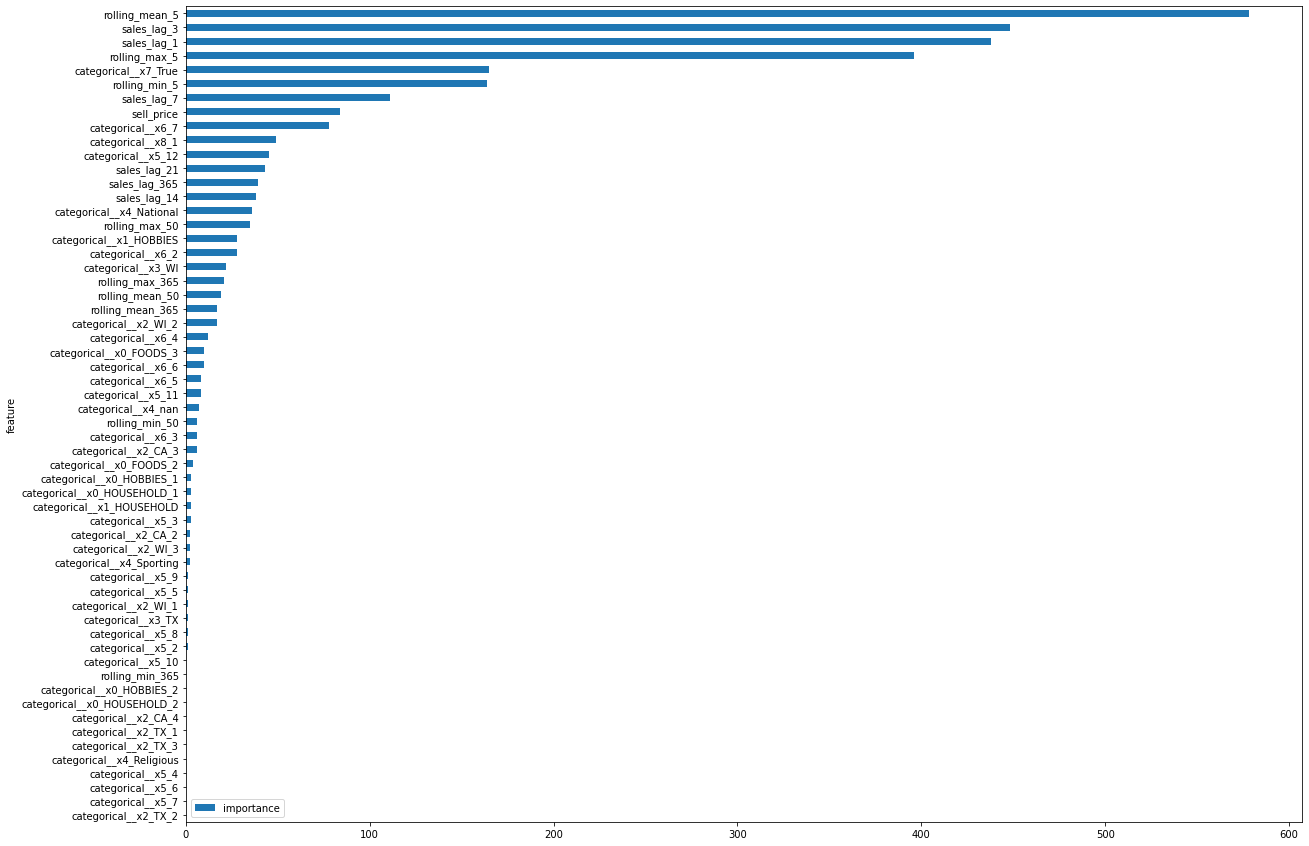

In [20]:
def plot_feature_importances(model: list, column_names: list):

    (
        pd.DataFrame(
            {'feature': column_names,
             'importance': model.feature_importances_, 
            }
        )
        .sort_values('importance', ascending=True)
        .set_index('feature')
        .plot(kind='barh', figsize=(20, 15)));
    
  # plot_feature_importances(gscv.best_estimator_['estimator'], feature_transformer.get_feature_names())  
plot_feature_importances(lgbm, feature_transformer.get_feature_names())

In [27]:
X_test[X_test['d'] == d]['preds'] =  gscv.best_estimator_.predict(X_test_one_step_)

/Users/wf07pu/miniconda3/envs/m5/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


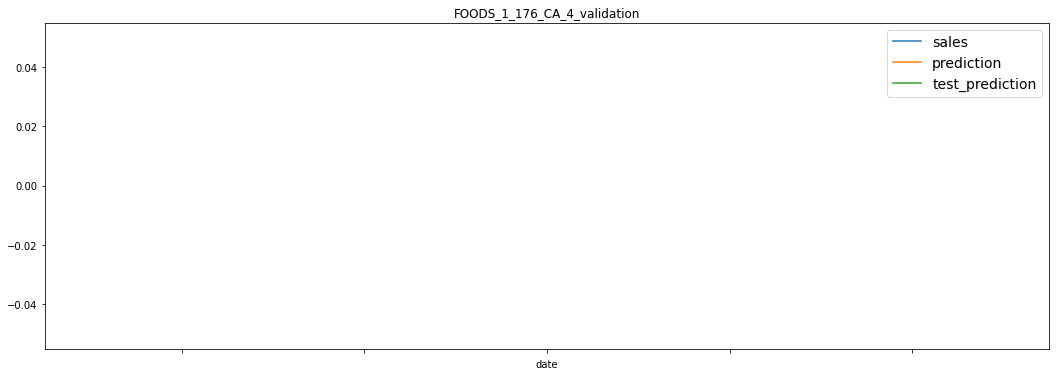

In [113]:
import matplotlib.pylab as plt

selected_id = np.unique(X['id'])[4]

selected_series = X_total[X_total['id'] == selected_id]

fig, ax = plt.subplots(figsize=(18,6))

selected_series.plot(x='date', y='sales', ax=ax, title=f"{selected_id}")
selected_series.plot(x='date', y='pred', ax=ax);
selected_series.plot(x='date', y='pred_test', ax=ax);

ax.legend(["sales", "prediction", "test_prediction"], prop={'size': 14});

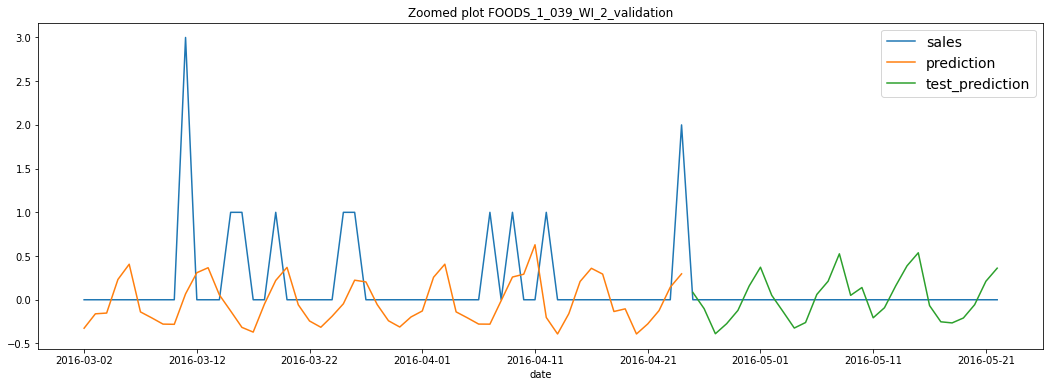

In [241]:
import matplotlib.pylab as plt

min_plot_date = '2016-03-01'

selected_id = np.unique(X['id'])[2]

selected_series = X_total[(X_total['id'] == selected_id) & (X_total['date'] > min_plot_date)]

fig, ax = plt.subplots(figsize=(18,6))

selected_series.plot(x='date', y='sales', ax=ax, title=f"Zoomed plot {selected_id}")
selected_series.plot(x='date', y='pred', ax=ax);
selected_series.plot(x='date', y='pred_test', ax=ax);

ax.legend(["sales", "prediction", "test_prediction"], prop={'size': 14});

In [263]:
from helpers import create_submission_file
    
submission_df = create_submission_file(X_test, days=forecast_days)

submission_df.to_csv('./submission.csv', index=False)